In [1]:
import os
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import psutil
import time

# Matrix sizes to test
matrix_sizes = [10, 20, 40, 80, 100, 120, 160, 200, 280, 360, 480, 600]

In [2]:

# Paths to the executables
generate_matrices_exec = './generate_matrices'
matrix_multiply_cpp_exec = './matrix_multiply_cpp'
matrix_multiply_rust_exec = './matrix_multiply_rust'

# Number of runs for each size to account for random errors
num_runs = 5

# Function to run a command and get the output
def run_command(command):
    result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    return result.stdout

# Function to measure memory usage using psutil
def measure_memory_usage(command):
    process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    peak_memory_usage = 0
    try:
        while process.poll() is None:
            memory_info = psutil.Process(process.pid).memory_info()
            peak_memory_usage = max(peak_memory_usage, memory_info.rss)
            time.sleep(0.01)  # Sleep briefly to reduce CPU usage
    except psutil.NoSuchProcess:
        pass
    finally:
        if process.poll() is None:
            process.terminate()
            process.wait()
    return peak_memory_usage / 1024  # Convert to KB

# Lists to store the results
cpp_total_times = []
cpp_mult_times = []
cpp_memory_usages = []
rust_total_times = []
rust_mult_times = []
rust_memory_usages = []

# Run the benchmarks
for size in matrix_sizes:
    cpp_total_run_times = []
    cpp_mult_run_times = []
    cpp_memory_run_usages = []
    rust_total_run_times = []
    rust_mult_run_times = []
    rust_memory_run_usages = []

    for _ in range(num_runs):
        # Generate matrices
        run_command([generate_matrices_exec, str(size)])
        
        # Measure memory usage for C++ matrix multiplication
        cpp_memory_usage = measure_memory_usage([matrix_multiply_cpp_exec, str(size)])
        cpp_memory_run_usages.append(cpp_memory_usage)
        
        # Run C++ matrix multiplication
        cpp_output = run_command([matrix_multiply_cpp_exec, str(size)])
        for line in cpp_output.split('\n'):
            if 'Total execution time' in line:
                cpp_total_time = float(line.split()[-1])
                cpp_total_run_times.append(cpp_total_time)
            if 'Matrix multiplication completion time' in line:
                cpp_mult_time = float(line.split()[-1])
                cpp_mult_run_times.append(cpp_mult_time)

        # Measure memory usage for Rust matrix multiplication
        rust_memory_usage = measure_memory_usage([matrix_multiply_rust_exec, str(size)])
        rust_memory_run_usages.append(rust_memory_usage)
        
        # Run Rust matrix multiplication
        rust_output = run_command([matrix_multiply_rust_exec, str(size)])
        for line in rust_output.split('\n'):
            if 'Total execution time' in line:
                rust_total_time = float(line.split()[-1])
                rust_total_run_times.append(rust_total_time)
            if 'Matrix multiplication completion time' in line:
                rust_mult_time = float(line.split()[-1])
                rust_mult_run_times.append(rust_mult_time)

    # Compute average and standard deviation
    cpp_total_times.append((np.mean(cpp_total_run_times), np.std(cpp_total_run_times)))
    cpp_mult_times.append((np.mean(cpp_mult_run_times), np.std(cpp_mult_run_times)))
    cpp_memory_usages.append((np.mean(cpp_memory_run_usages), np.std(cpp_memory_run_usages)))
    rust_total_times.append((np.mean(rust_total_run_times), np.std(rust_total_run_times)))
    rust_mult_times.append((np.mean(rust_mult_run_times), np.std(rust_mult_run_times)))
    rust_memory_usages.append((np.mean(rust_memory_run_usages), np.std(rust_memory_run_usages)))

# Save the results to a text file
with open('benchmark_results.txt', 'w') as f:
    f.write("Matrix Size,CPP Total Mean,CPP Total Std,CPP Mult Mean,CPP Mult Std,CPP Mem Mean,CPP Mem Std,Rust Total Mean,Rust Total Std,Rust Mult Mean,Rust Mult Std,Rust Mem Mean,Rust Mem Std\n")
    for size, cpp_total, cpp_mult, cpp_mem, rust_total, rust_mult, rust_mem in zip(matrix_sizes, cpp_total_times, cpp_mult_times, cpp_memory_usages, rust_total_times, rust_mult_times, rust_memory_usages):
        f.write(f"{size},{cpp_total[0]},{cpp_total[1]},{cpp_mult[0]},{cpp_mult[1]},{cpp_mem[0]},{cpp_mem[1]},{rust_total[0]},{rust_total[1]},{rust_mult[0]},{rust_mult[1]},{rust_mem[0]},{rust_mem[1]}\n")


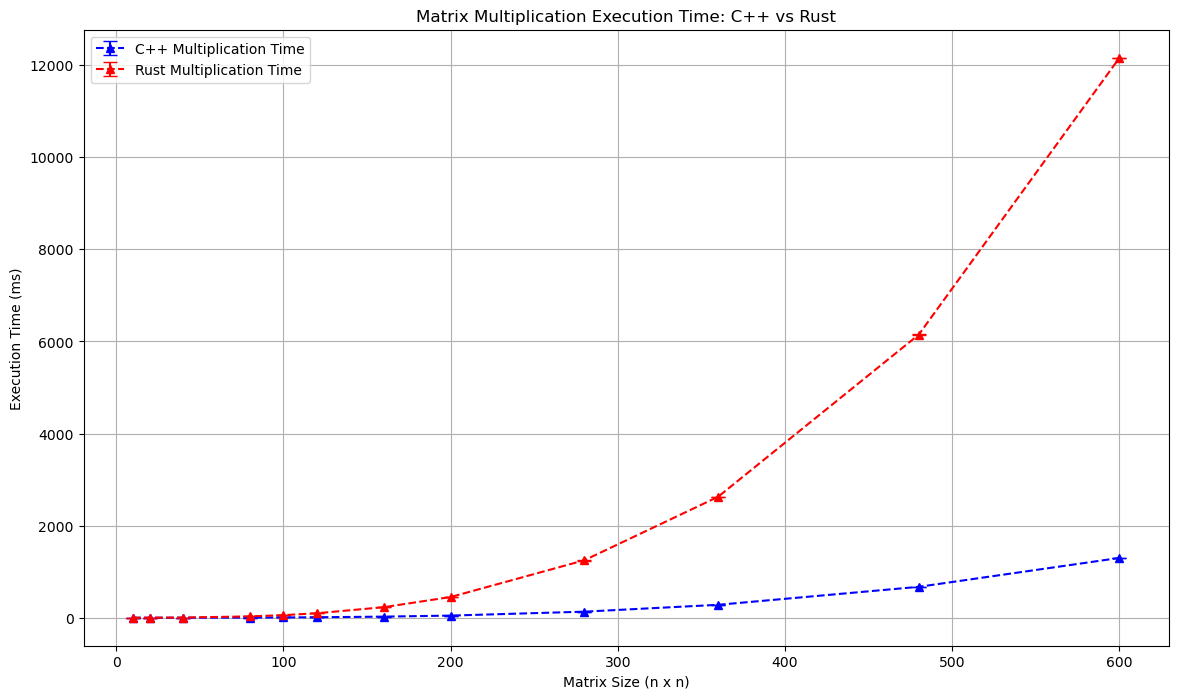

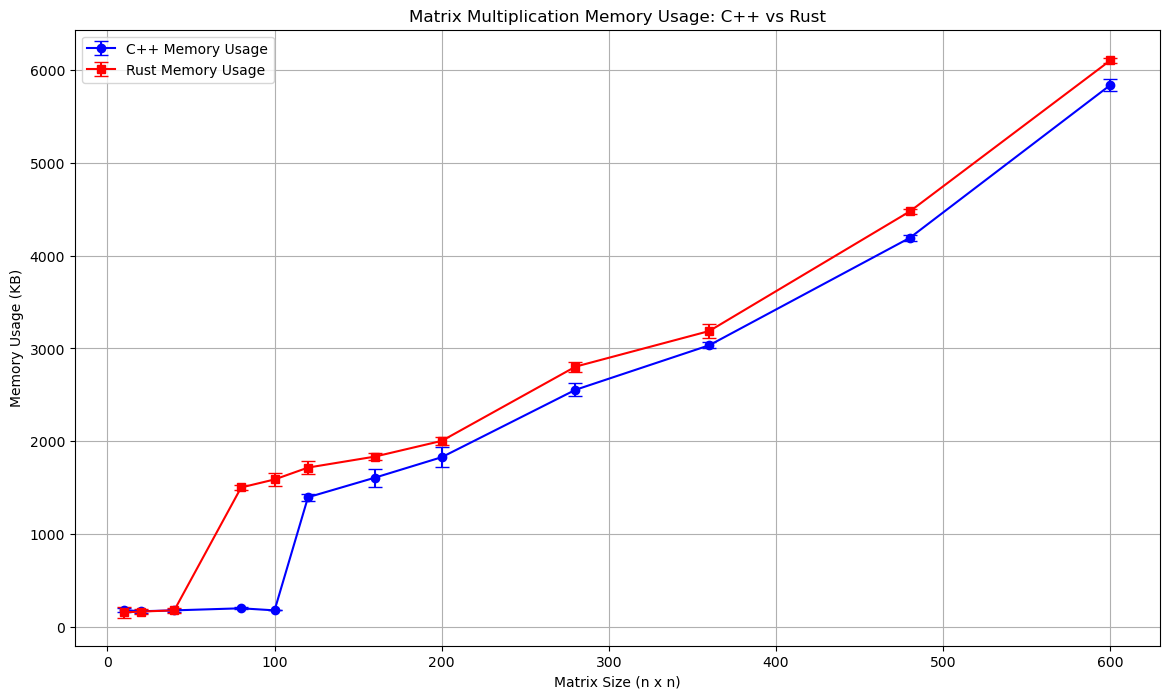

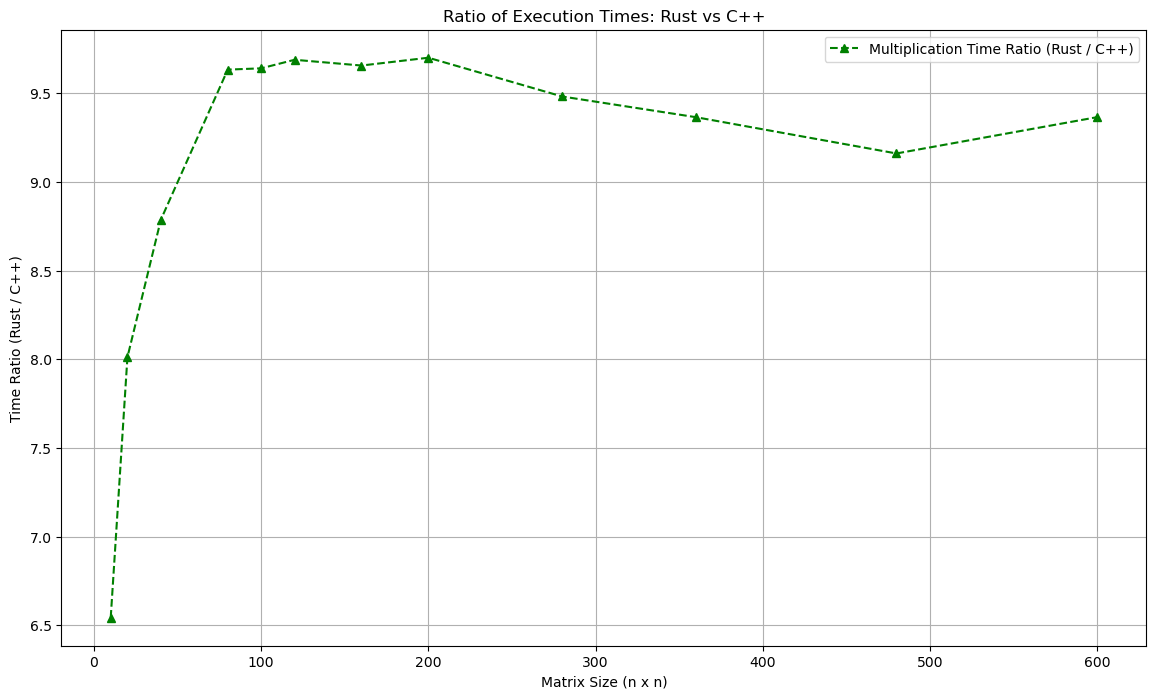

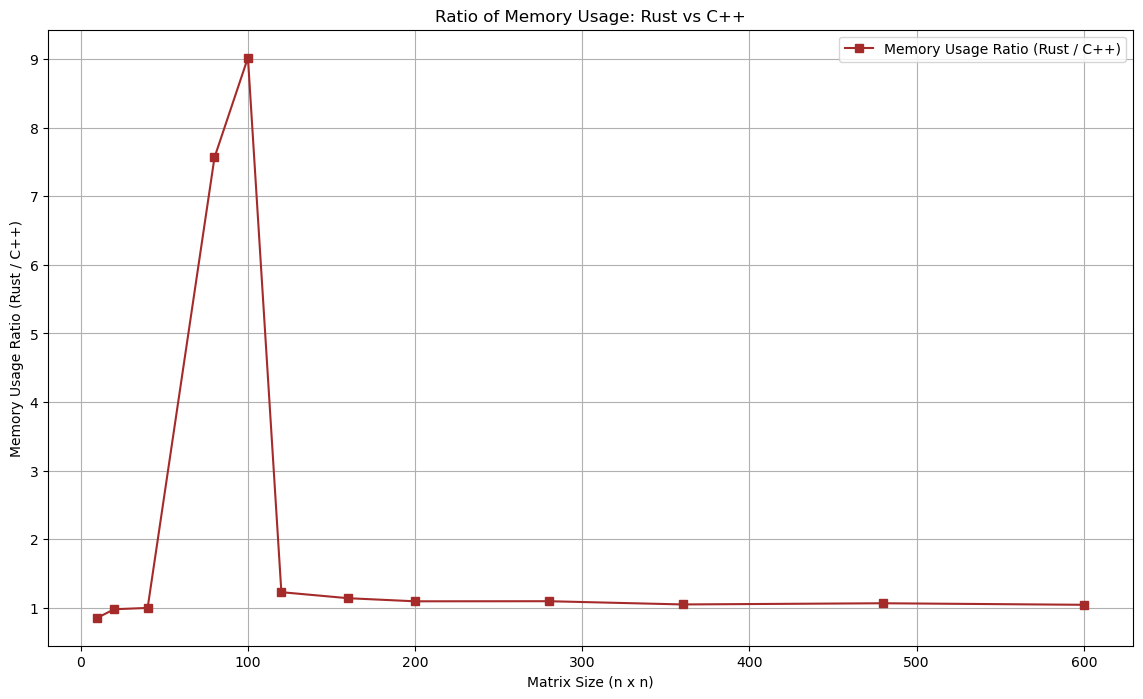

In [5]:
# Plotting the results
matrix_sizes = np.array(matrix_sizes)
cpp_total_means = np.array([x[0] for x in cpp_total_times])
cpp_total_stds = np.array([x[1] for x in cpp_total_times])
cpp_mult_means = np.array([x[0] for x in cpp_mult_times])
cpp_mult_stds = np.array([x[1] for x in cpp_mult_times])
cpp_memory_means = np.array([x[0] for x in cpp_memory_usages])
cpp_memory_stds = np.array([x[1] for x in cpp_memory_usages])
rust_total_means = np.array([x[0] for x in rust_total_times])
rust_total_stds = np.array([x[1] for x in rust_total_times])
rust_mult_means = np.array([x[0] for x in rust_mult_times])
rust_mult_stds = np.array([x[1] for x in rust_mult_times])
rust_memory_means = np.array([x[0] for x in rust_memory_usages])
rust_memory_stds = np.array([x[1] for x in rust_memory_usages])

# Calculate the ratio/difference between C++ and Rust execution times
total_time_ratios = rust_total_means / cpp_total_means
mult_time_ratios = rust_mult_means / cpp_mult_means
memory_usage_ratios = rust_memory_means / cpp_memory_means

plt.figure(figsize=(14, 8))


# Plot for Matrix Multiplication Time
plt.errorbar(matrix_sizes, cpp_mult_means, yerr=cpp_mult_stds, label='C++ Multiplication Time', marker='^', linestyle='--', color='blue', capsize=5)
plt.errorbar(matrix_sizes, rust_mult_means, yerr=rust_mult_stds, label='Rust Multiplication Time', marker='^', linestyle='--', color='red', capsize=5)

plt.xlabel('Matrix Size (n x n)')
plt.ylabel('Execution Time (ms)')
plt.title('Matrix Multiplication Execution Time: C++ vs Rust')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 8))

plt.errorbar(matrix_sizes, cpp_memory_means, yerr=cpp_memory_stds, label='C++ Memory Usage', marker='o', linestyle='-', color='blue', capsize=5)
plt.errorbar(matrix_sizes, rust_memory_means, yerr=rust_memory_stds, label='Rust Memory Usage', marker='s', linestyle='-', color='red', capsize=5)

plt.xlabel('Matrix Size (n x n)')
plt.ylabel('Memory Usage (KB)')
plt.title('Matrix Multiplication Memory Usage: C++ vs Rust')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 8))

# Plot for the ratio/difference of Total Time and Multiplication Time
plt.plot(matrix_sizes, mult_time_ratios, label='Multiplication Time Ratio (Rust / C++)', marker='^', linestyle='--', color='green')

plt.xlabel('Matrix Size (n x n)')
plt.ylabel('Time Ratio (Rust / C++)')
plt.title('Ratio of Execution Times: Rust vs C++')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 8))

# Plot for the ratio of memory usage
plt.plot(matrix_sizes, memory_usage_ratios, label='Memory Usage Ratio (Rust / C++)', marker='s', linestyle='-', color='brown')

plt.xlabel('Matrix Size (n x n)')
plt.ylabel('Memory Usage Ratio (Rust / C++)')
plt.title('Ratio of Memory Usage: Rust vs C++')
plt.legend()
plt.grid(True)
plt.show()

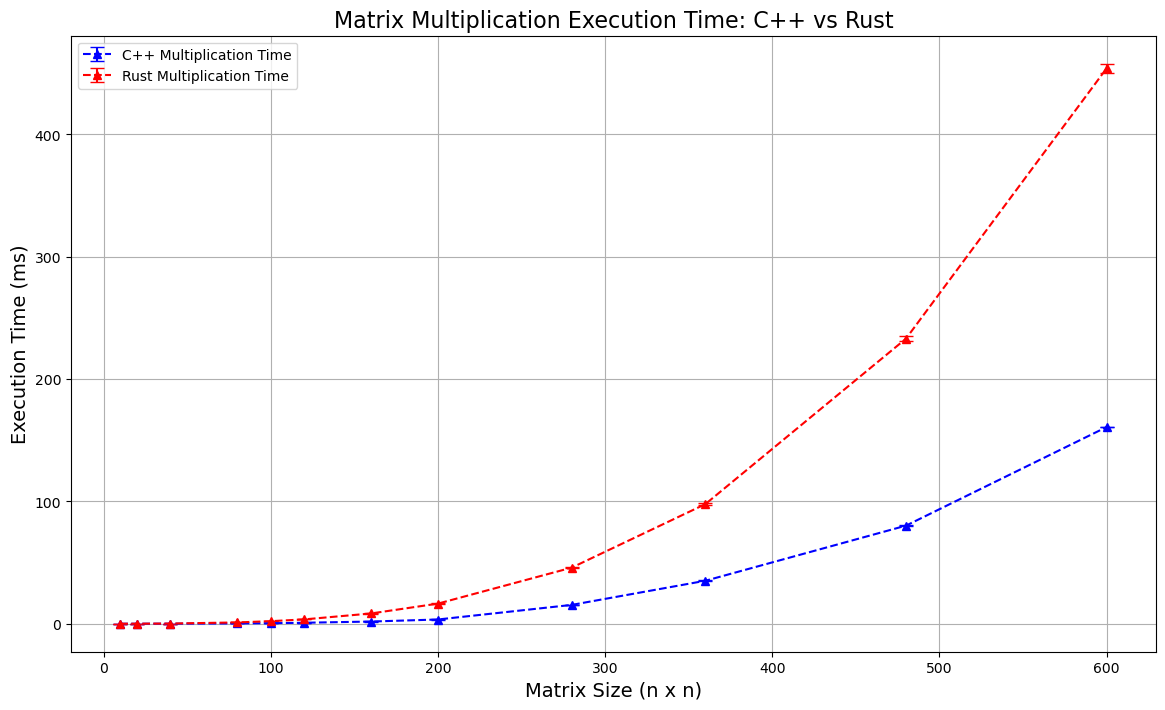

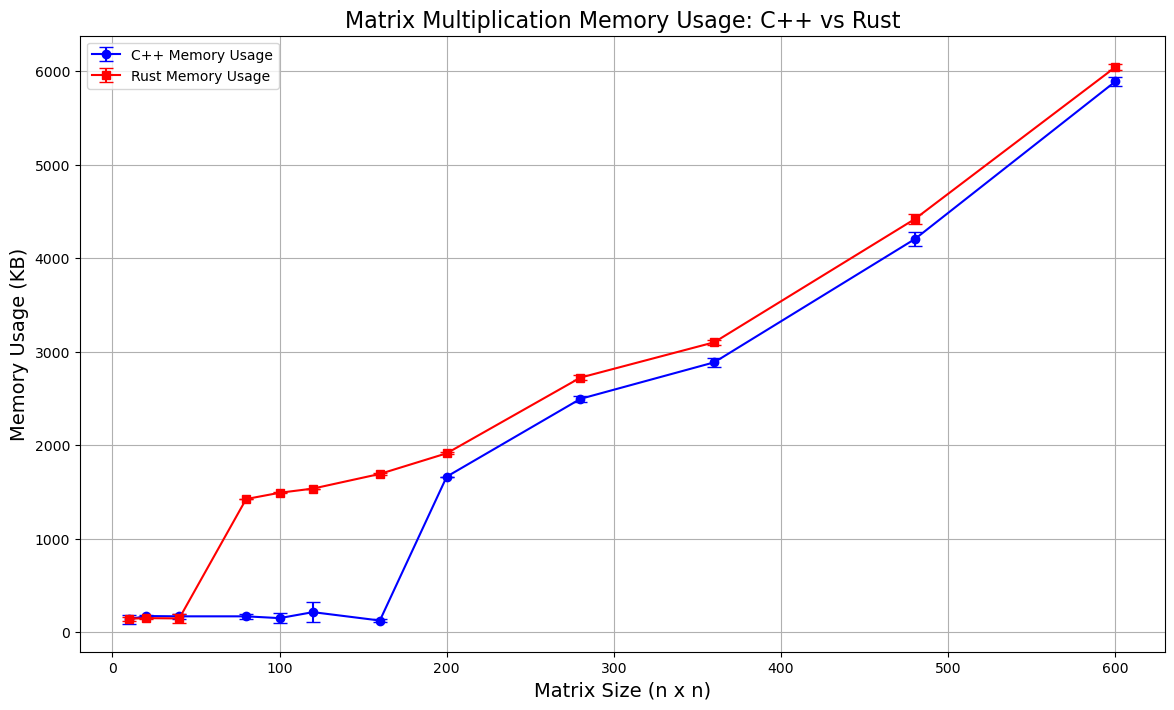

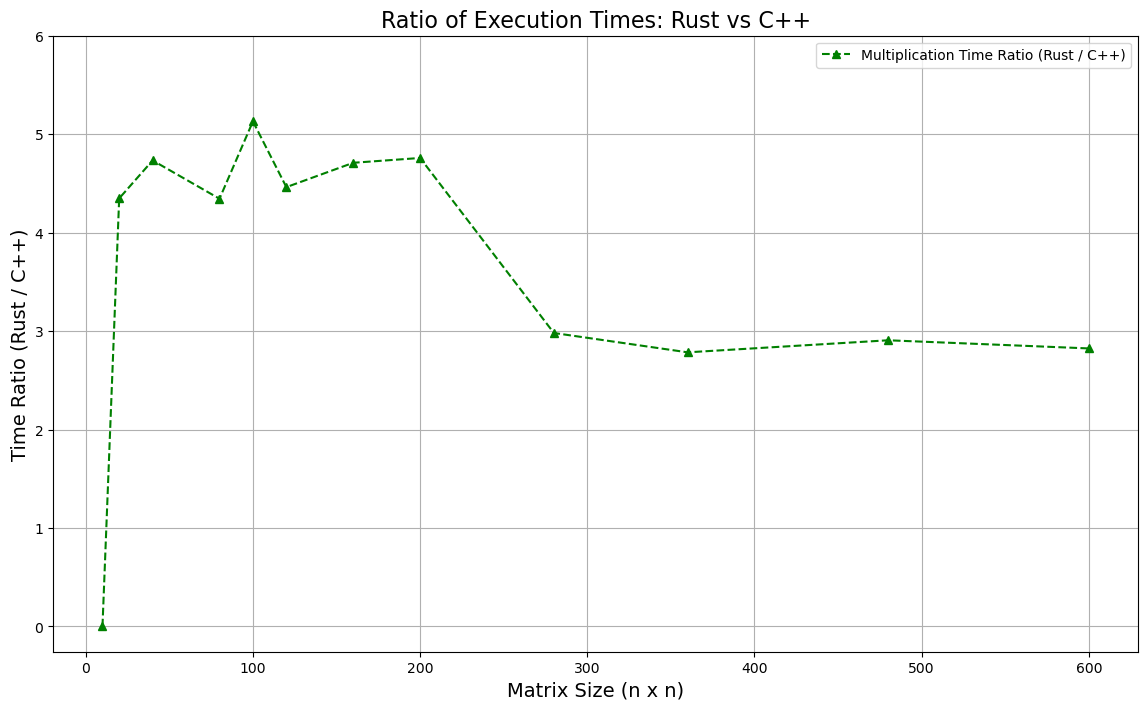

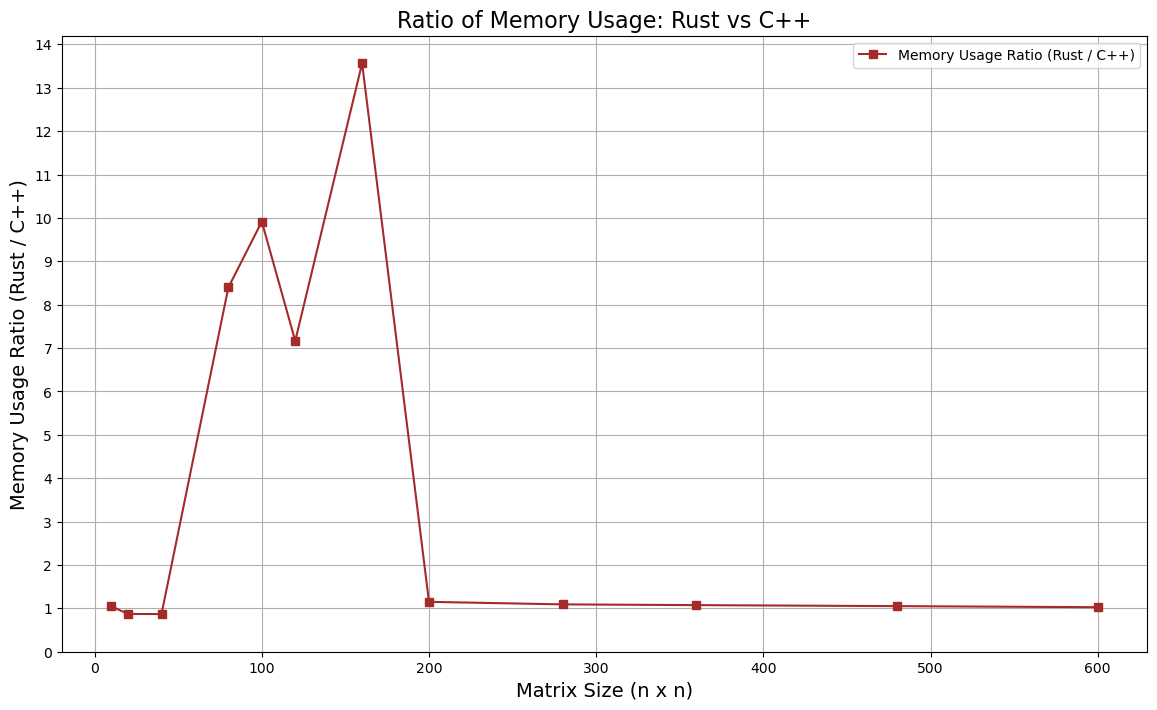

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming matrix_sizes, cpp_mult_times, cpp_memory_usages, rust_mult_times, rust_memory_usages are defined

matrix_sizes = np.array(matrix_sizes)
cpp_mult_means = np.array([x[0] for x in cpp_mult_times])
cpp_mult_stds = np.array([x[1] for x in cpp_mult_times])
cpp_memory_means = np.array([x[0] for x in cpp_memory_usages])
cpp_memory_stds = np.array([x[1] for x in cpp_memory_usages])
rust_mult_means = np.array([x[0] for x in rust_mult_times])
rust_mult_stds = np.array([x[1] for x in rust_mult_times])
rust_memory_means = np.array([x[0] for x in rust_memory_usages])
rust_memory_stds = np.array([x[1] for x in rust_memory_usages])

# Calculate the ratio/difference between C++ and Rust execution times
mult_time_ratios = rust_mult_means / cpp_mult_means
memory_usage_ratios = rust_memory_means / cpp_memory_means

plt.figure(figsize=(14, 8))

# Plot for Matrix Multiplication Time
plt.errorbar(matrix_sizes, cpp_mult_means, yerr=cpp_mult_stds, label='C++ Multiplication Time', marker='^', linestyle='--', color='blue', capsize=5)
plt.errorbar(matrix_sizes, rust_mult_means, yerr=rust_mult_stds, label='Rust Multiplication Time', marker='^', linestyle='--', color='red', capsize=5)

plt.xlabel('Matrix Size (n x n)', fontsize=14)
plt.ylabel('Execution Time (ms)', fontsize=14)
plt.title('Matrix Multiplication Execution Time: C++ vs Rust', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 8))

plt.errorbar(matrix_sizes, cpp_memory_means, yerr=cpp_memory_stds, label='C++ Memory Usage', marker='o', linestyle='-', color='blue', capsize=5)
plt.errorbar(matrix_sizes, rust_memory_means, yerr=rust_memory_stds, label='Rust Memory Usage', marker='s', linestyle='-', color='red', capsize=5)

plt.xlabel('Matrix Size (n x n)', fontsize=14)
plt.ylabel('Memory Usage (KB)', fontsize=14)
plt.title('Matrix Multiplication Memory Usage: C++ vs Rust', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 8))

# Plot for the ratio/difference of Multiplication Time
plt.plot(matrix_sizes, mult_time_ratios, label='Multiplication Time Ratio (Rust / C++)', marker='^', linestyle='--', color='green')

plt.xlabel('Matrix Size (n x n)', fontsize=14)
plt.ylabel('Time Ratio (Rust / C++)', fontsize=14)
plt.title('Ratio of Execution Times: Rust vs C++', fontsize=16)
plt.legend()
plt.grid(True)
plt.yticks(np.arange(0, np.max(mult_time_ratios) + 1, 1))
plt.show()

plt.figure(figsize=(14, 8))

# Plot for the ratio of memory usage
plt.plot(matrix_sizes, memory_usage_ratios, label='Memory Usage Ratio (Rust / C++)', marker='s', linestyle='-', color='brown')

plt.xlabel('Matrix Size (n x n)', fontsize=14)
plt.ylabel('Memory Usage Ratio (Rust / C++)', fontsize=14)
plt.title('Ratio of Memory Usage: Rust vs C++', fontsize=16)
plt.legend()
plt.grid(True)
plt.yticks(np.arange(0, np.max(memory_usage_ratios) + 1, 1))
plt.show()


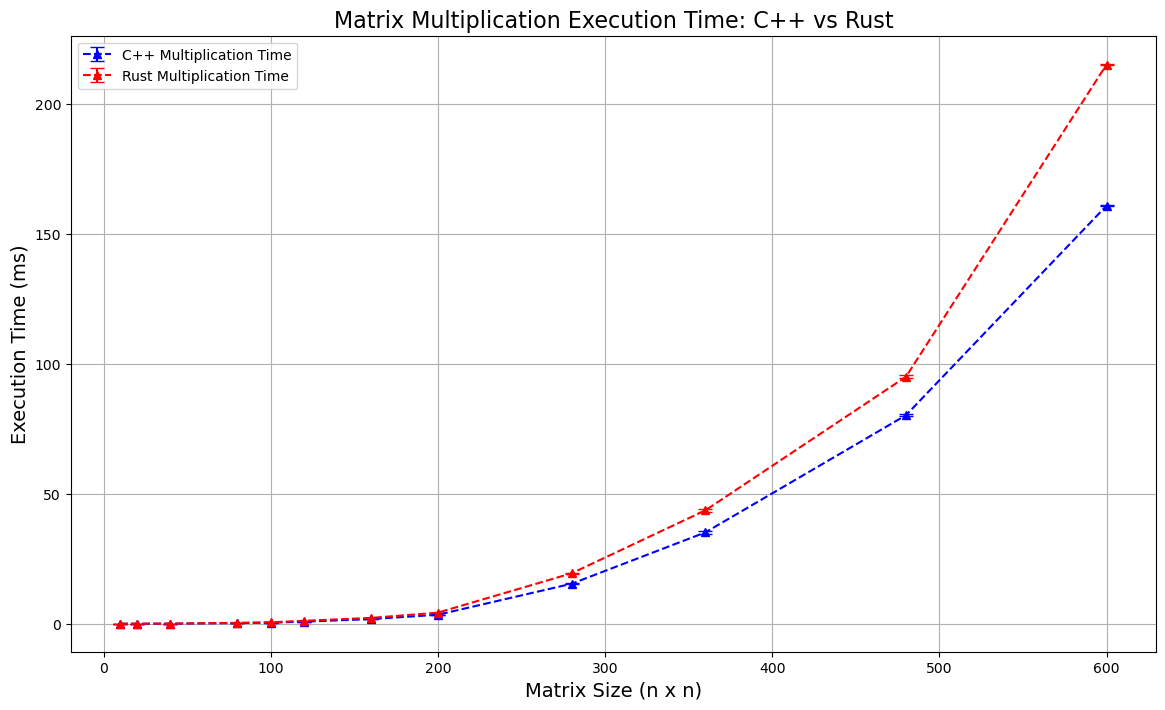

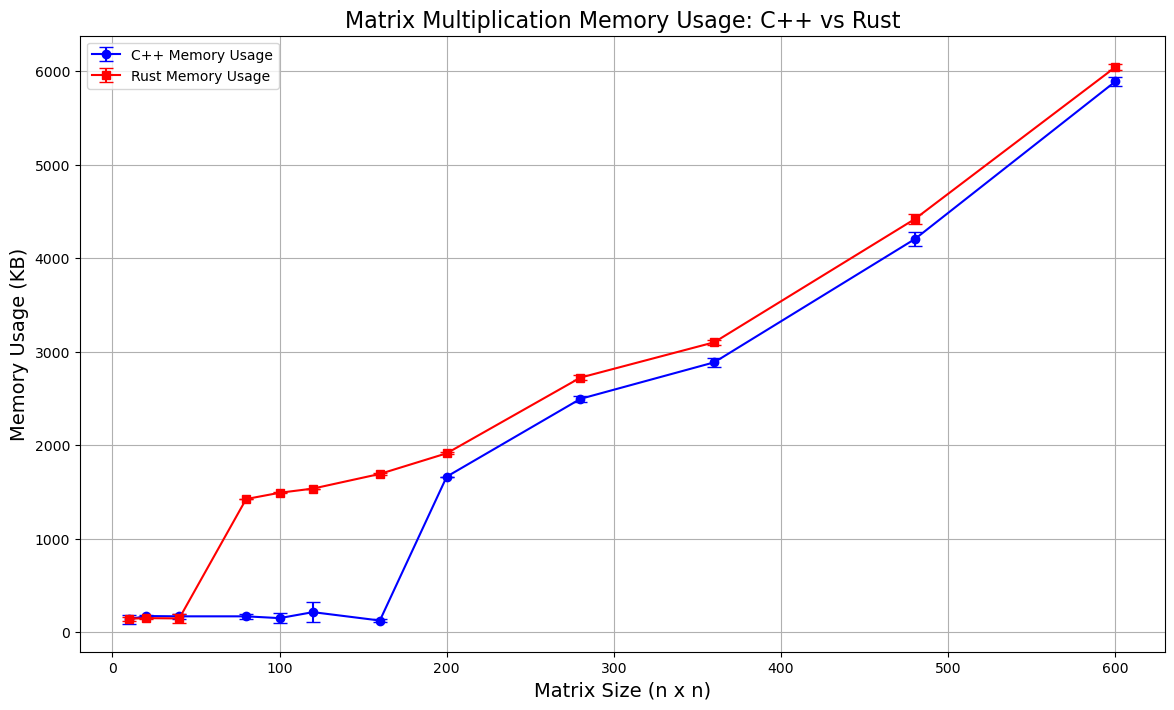

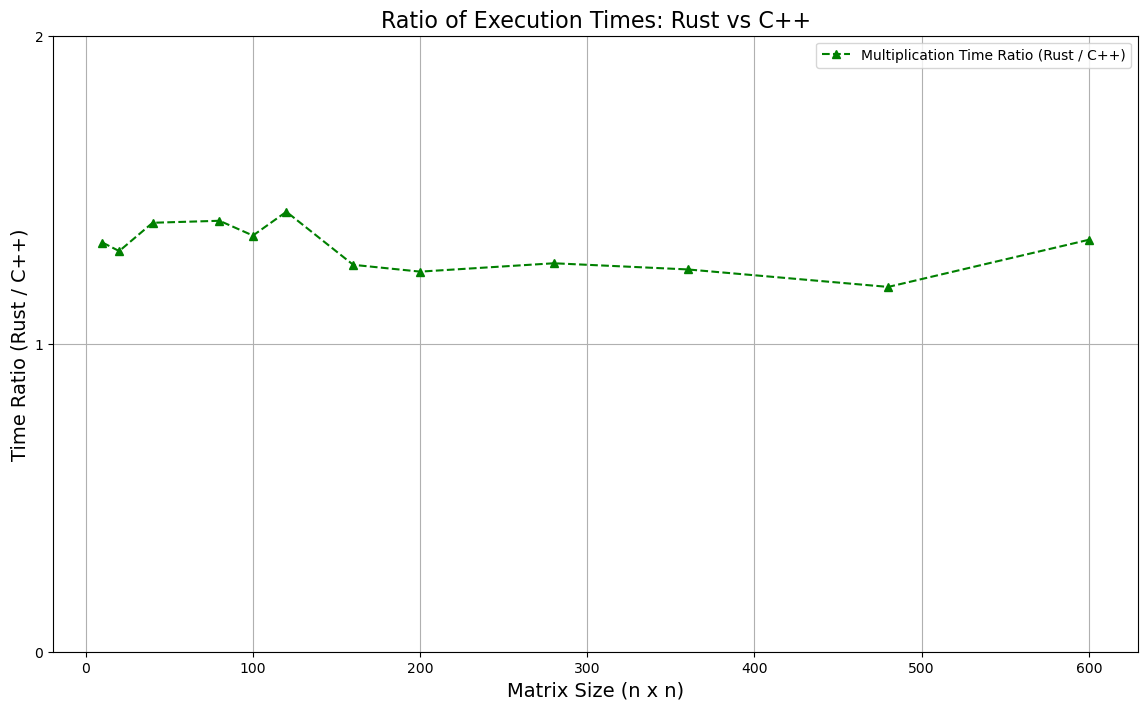

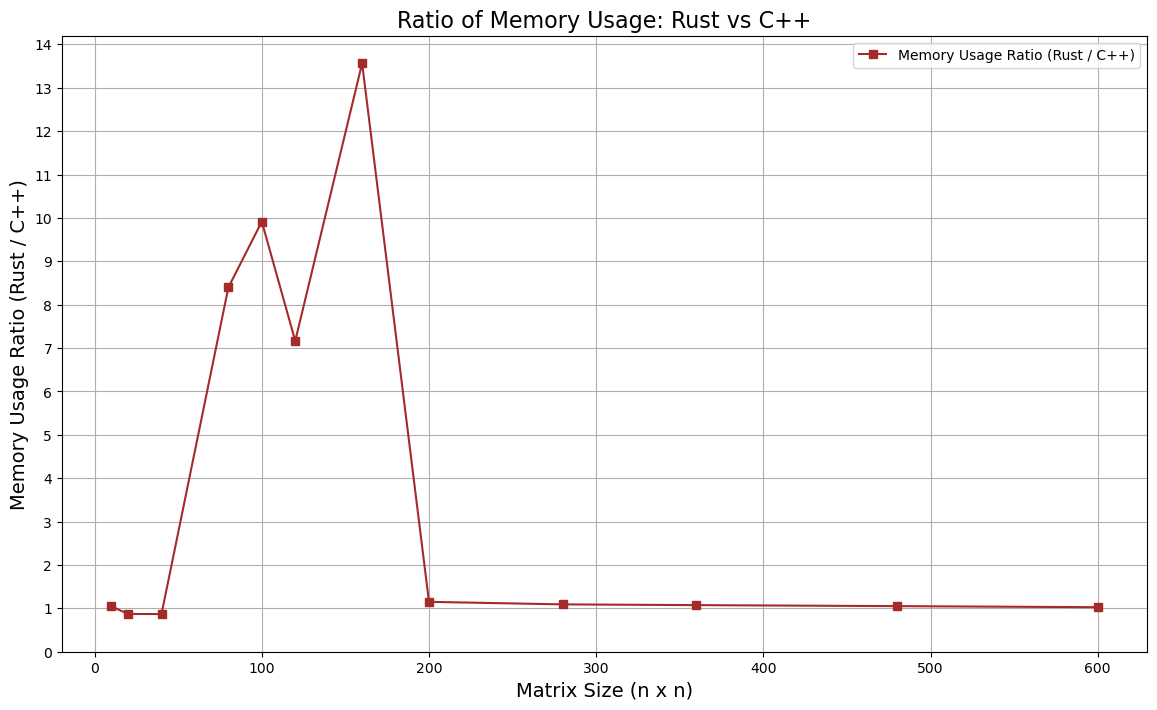

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Read data from the file
data = np.genfromtxt('benchmark_results.txt', delimiter=',', skip_header=1)

# Extract the columns into variables
matrix_sizes = data[:, 0]
cpp_total_means = data[:, 1]
cpp_total_stds = data[:, 2]
cpp_mult_means = data[:, 3]
cpp_mult_stds = data[:, 4]
cpp_memory_means = data[:, 5]
cpp_memory_stds = data[:, 6]
rust_total_means = data[:, 7]
rust_total_stds = data[:, 8]
rust_mult_means = data[:, 9]
rust_mult_stds = data[:, 10]
rust_memory_means = data[:, 11]
rust_memory_stds = data[:, 12]


# Calculate the ratio/difference between C++ and Rust execution times
mult_time_ratios = rust_mult_means / cpp_mult_means
memory_usage_ratios = rust_memory_means / cpp_memory_means

plt.figure(figsize=(14, 8))

# Plot for Matrix Multiplication Time
plt.errorbar(matrix_sizes, cpp_mult_means, yerr=cpp_mult_stds, label='C++ Multiplication Time', marker='^', linestyle='--', color='blue', capsize=5)
plt.errorbar(matrix_sizes, rust_mult_means, yerr=rust_mult_stds, label='Rust Multiplication Time', marker='^', linestyle='--', color='red', capsize=5)

plt.xlabel('Matrix Size (n x n)', fontsize=14)
plt.ylabel('Execution Time (ms)', fontsize=14)
plt.title('Matrix Multiplication Execution Time: C++ vs Rust', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 8))

plt.errorbar(matrix_sizes, cpp_memory_means, yerr=cpp_memory_stds, label='C++ Memory Usage', marker='o', linestyle='-', color='blue', capsize=5)
plt.errorbar(matrix_sizes, rust_memory_means, yerr=rust_memory_stds, label='Rust Memory Usage', marker='s', linestyle='-', color='red', capsize=5)

plt.xlabel('Matrix Size (n x n)', fontsize=14)
plt.ylabel('Memory Usage (KB)', fontsize=14)
plt.title('Matrix Multiplication Memory Usage: C++ vs Rust', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 8))

# Plot for the ratio/difference of Multiplication Time
plt.plot(matrix_sizes, mult_time_ratios, label='Multiplication Time Ratio (Rust / C++)', marker='^', linestyle='--', color='green')

plt.xlabel('Matrix Size (n x n)', fontsize=14)
plt.ylabel('Time Ratio (Rust / C++)', fontsize=14)
plt.title('Ratio of Execution Times: Rust vs C++', fontsize=16)
plt.legend()
plt.grid(True)
plt.yticks(np.arange(0, np.max(mult_time_ratios) + 1, 1))
plt.show()

plt.figure(figsize=(14, 8))

# Plot for the ratio of memory usage
plt.plot(matrix_sizes, memory_usage_ratios, label='Memory Usage Ratio (Rust / C++)', marker='s', linestyle='-', color='brown')

plt.xlabel('Matrix Size (n x n)', fontsize=14)
plt.ylabel('Memory Usage Ratio (Rust / C++)', fontsize=14)
plt.title('Ratio of Memory Usage: Rust vs C++', fontsize=16)
plt.legend()
plt.grid(True)
plt.yticks(np.arange(0, np.max(memory_usage_ratios) + 1, 1))
plt.show()


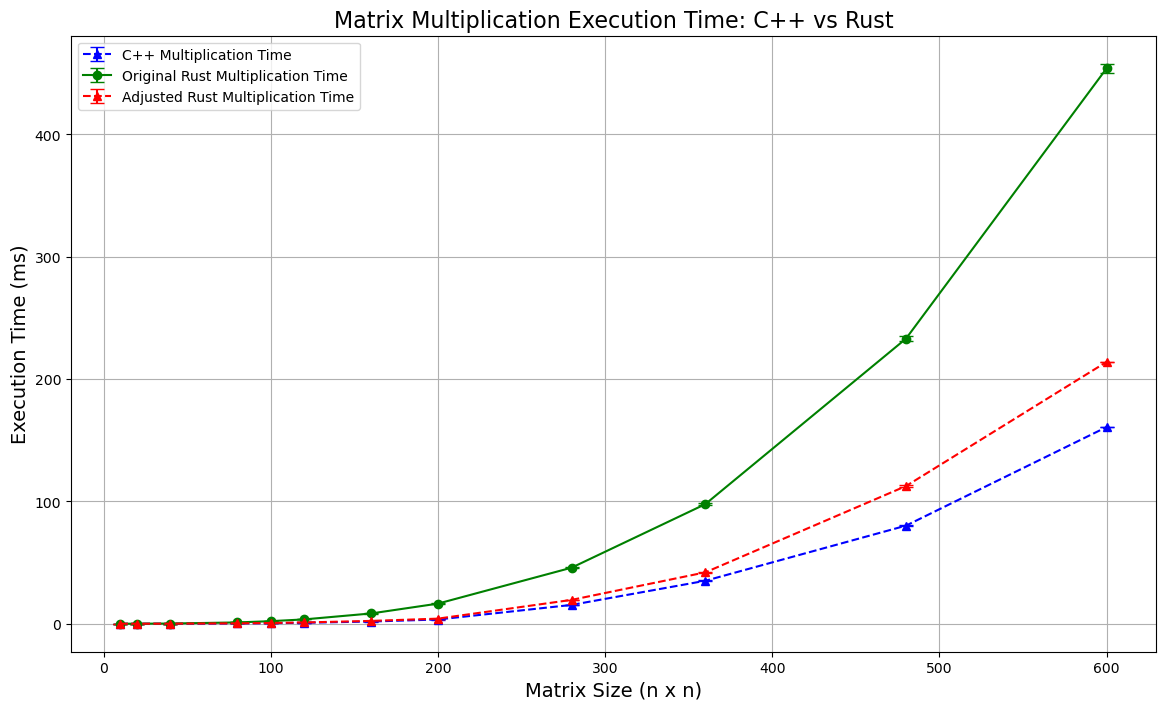

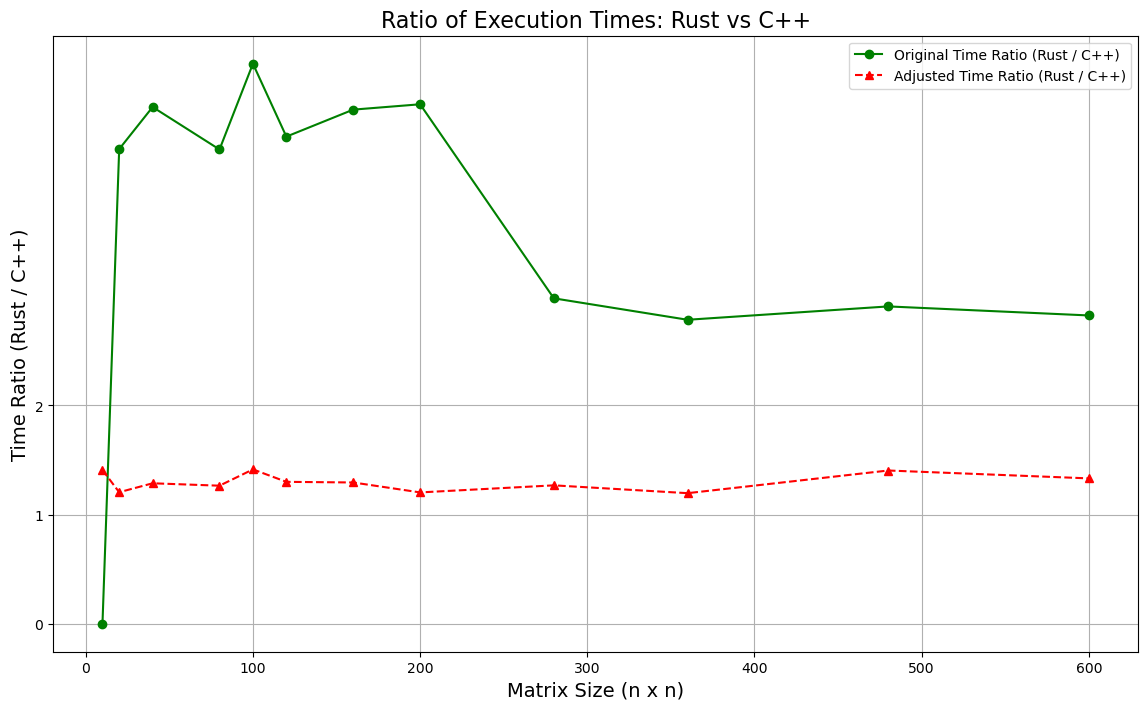

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Read data from the file
data = np.genfromtxt('benchmark_results.txt', delimiter=',', skip_header=1)

# Extract the columns into variables
matrix_sizes = data[:, 0]
cpp_mult_means = data[:, 3]
cpp_mult_stds = data[:, 4]
rust_mult_means = data[:, 9]
rust_mult_stds = data[:, 10]

# Save original Rust execution times
original_rust_mult_means = np.copy(rust_mult_means)
original_rust_mult_stds = np.copy(rust_mult_stds)



# Calculate the ratio/difference between C++ and Rust execution times
original_mult_time_ratios = original_rust_mult_means / cpp_mult_means
adjusted_mult_time_ratios = adjusted_rust_mult_means / cpp_mult_means

plt.figure(figsize=(14, 8))

# Plot for Matrix Multiplication Time
plt.errorbar(matrix_sizes, cpp_mult_means, yerr=cpp_mult_stds, label='C++ Multiplication Time', marker='^', linestyle='--', color='blue', capsize=5)
plt.errorbar(matrix_sizes, original_rust_mult_means, yerr=original_rust_mult_stds, label='Original Rust Multiplication Time', marker='o', linestyle='-', color='green', capsize=5)
plt.errorbar(matrix_sizes, adjusted_rust_mult_means, yerr=adjusted_rust_mult_stds, label='Adjusted Rust Multiplication Time', marker='^', linestyle='--', color='red', capsize=5)

plt.xlabel('Matrix Size (n x n)', fontsize=14)
plt.ylabel('Execution Time (ms)', fontsize=14)
plt.title('Matrix Multiplication Execution Time: C++ vs Rust', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 8))

# Plot for the ratio of original and adjusted Rust to C++ execution times
plt.plot(matrix_sizes, original_mult_time_ratios, label='Original Time Ratio (Rust / C++)', marker='o', linestyle='-', color='green')
plt.plot(matrix_sizes, adjusted_mult_time_ratios, label='Adjusted Time Ratio (Rust / C++)', marker='^', linestyle='--', color='red')

plt.xlabel('Matrix Size (n x n)', fontsize=14)
plt.ylabel('Time Ratio (Rust / C++)', fontsize=14)
plt.title('Ratio of Execution Times: Rust vs C++', fontsize=16)
plt.legend()
plt.grid(True)
plt.yticks(np.arange(0, np.max(adjusted_mult_time_ratios) + 1, 1))
plt.show()


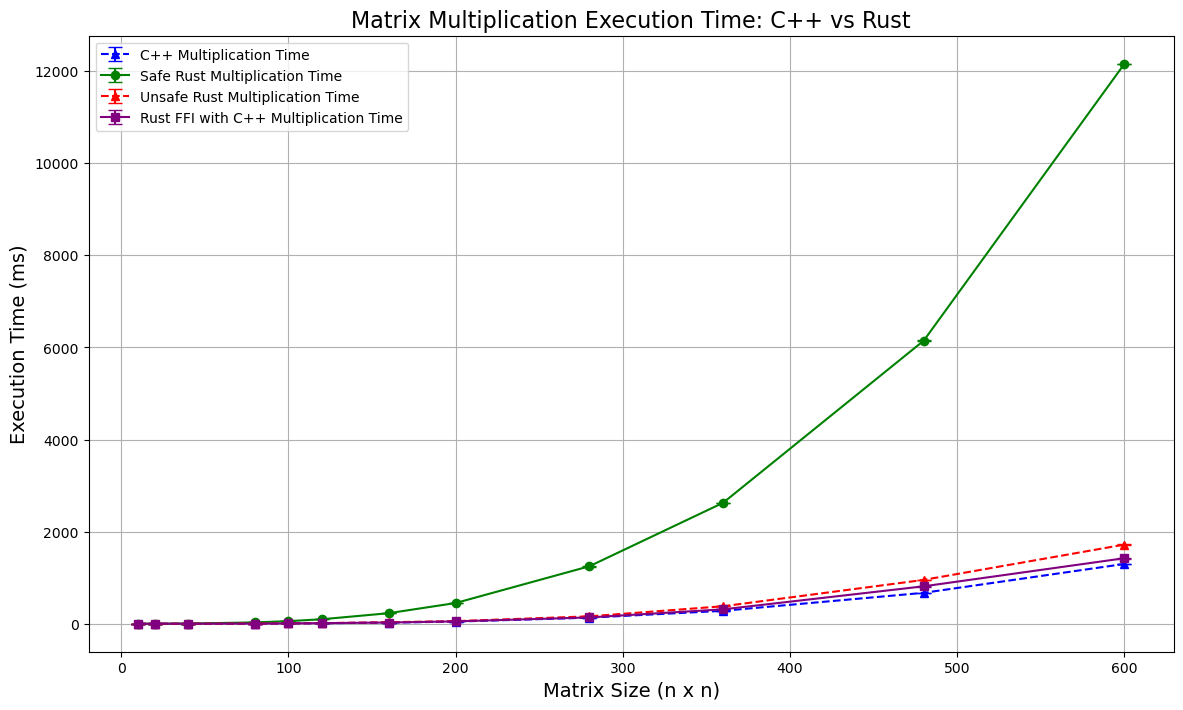

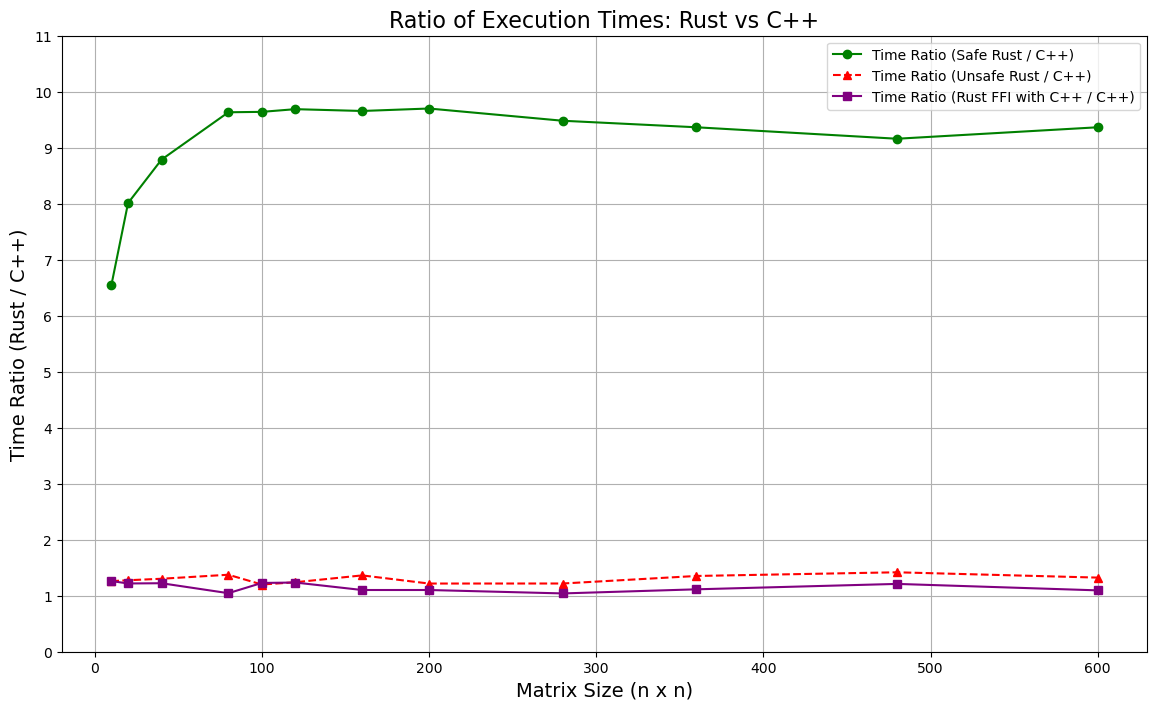

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Read data from the file
data = np.genfromtxt('benchmark_results.txt', delimiter=',', skip_header=1)

# Extract the columns into variables
matrix_sizes = data[:, 0]
cpp_mult_means = data[:, 3]
cpp_mult_stds = data[:, 4]
rust_mult_means = data[:, 9]
rust_mult_stds = data[:, 10]

# Save original Rust execution times
original_rust_mult_means = np.copy(rust_mult_means)
original_rust_mult_stds = np.copy(rust_mult_stds)



# Calculate the ratio/difference between C++ and Rust execution times
original_mult_time_ratios = original_rust_mult_means / cpp_mult_means
adjusted_mult_time_ratios = adjusted_rust_mult_means / cpp_mult_means
ffi_mult_time_ratios = ffi_rust_mult_means / cpp_mult_means

plt.figure(figsize=(14, 8))

# Plot for Matrix Multiplication Time
plt.errorbar(matrix_sizes, cpp_mult_means, yerr=cpp_mult_stds, label='C++ Multiplication Time', marker='^', linestyle='--', color='blue', capsize=5)
plt.errorbar(matrix_sizes, original_rust_mult_means, yerr=original_rust_mult_stds, label='Safe Rust Multiplication Time', marker='o', linestyle='-', color='green', capsize=5)
plt.errorbar(matrix_sizes, adjusted_rust_mult_means, yerr=adjusted_rust_mult_stds, label='Unsafe Rust Multiplication Time', marker='^', linestyle='--', color='red', capsize=5)
plt.errorbar(matrix_sizes, ffi_rust_mult_means, yerr=ffi_rust_mult_stds, label='Rust FFI with C++ Multiplication Time', marker='s', linestyle='-', color='purple', capsize=5)

plt.xlabel('Matrix Size (n x n)', fontsize=14)
plt.ylabel('Execution Time (ms)', fontsize=14)
plt.title('Matrix Multiplication Execution Time: C++ vs Rust', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 8))

# Plot for the ratio of original, adjusted, and FFI Rust to C++ execution times
plt.plot(matrix_sizes, original_mult_time_ratios, label='Time Ratio (Safe Rust / C++)', marker='o', linestyle='-', color='green')
plt.plot(matrix_sizes, adjusted_mult_time_ratios, label='Time Ratio (Unsafe Rust / C++)', marker='^', linestyle='--', color='red')
plt.plot(matrix_sizes, ffi_mult_time_ratios, label='Time Ratio (Rust FFI with C++ / C++)', marker='s', linestyle='-', color='purple')

plt.xlabel('Matrix Size (n x n)', fontsize=14)
plt.ylabel('Time Ratio (Rust / C++)', fontsize=14)
plt.title('Ratio of Execution Times: Rust vs C++', fontsize=16)
plt.legend()
plt.grid(True)
plt.yticks(np.arange(0, np.max(ffi_mult_time_ratios) + 10, 1))
plt.show()


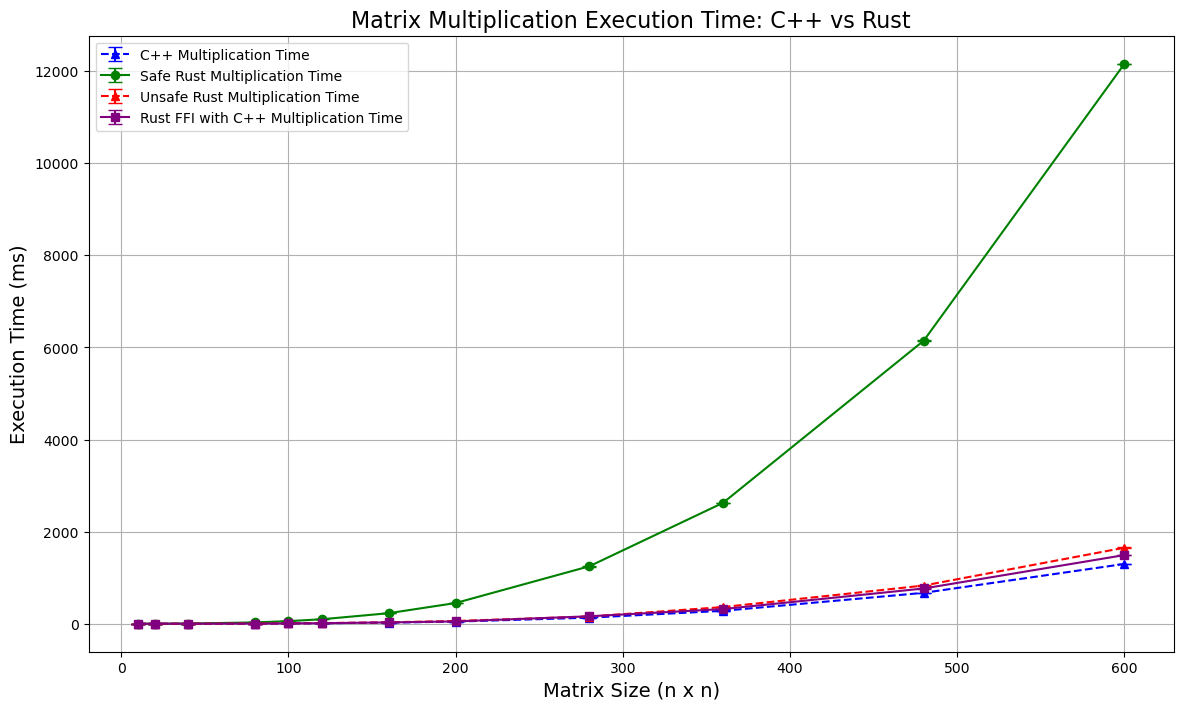

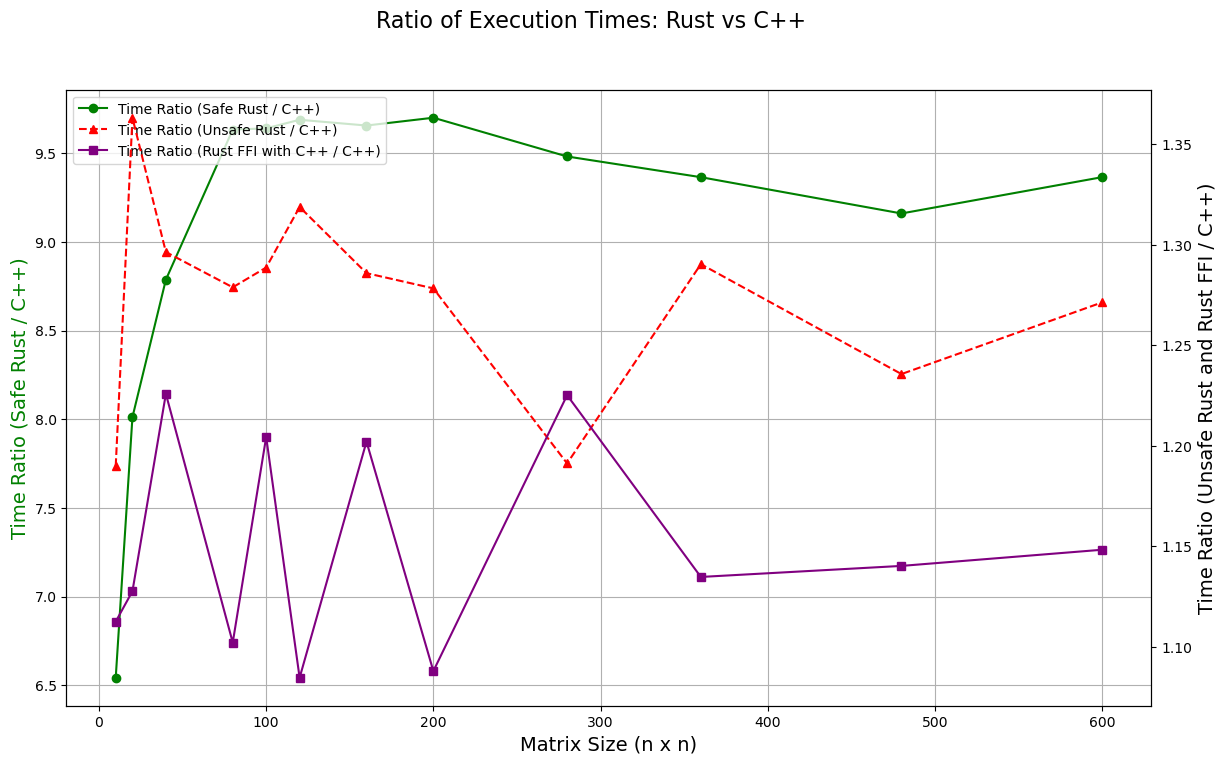

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Read data from the file
data = np.genfromtxt('benchmark_results.txt', delimiter=',', skip_header=1)

# Extract the columns into variables
matrix_sizes = data[:, 0]
cpp_mult_means = data[:, 3]
cpp_mult_stds = data[:, 4]
rust_mult_means = data[:, 9]
rust_mult_stds = data[:, 10]

# Save original Rust execution times
original_rust_mult_means = np.copy(rust_mult_means)
original_rust_mult_stds = np.copy(rust_mult_stds)

# Calculate the ratio/difference between C++ and Rust execution times
original_mult_time_ratios = original_rust_mult_means / cpp_mult_means
adjusted_mult_time_ratios = adjusted_rust_mult_means / cpp_mult_means
ffi_mult_time_ratios = ffi_rust_mult_means / cpp_mult_means

plt.figure(figsize=(14, 8))

# Plot for Matrix Multiplication Time
plt.errorbar(matrix_sizes, cpp_mult_means, yerr=cpp_mult_stds, label='C++ Multiplication Time', marker='^', linestyle='--', color='blue', capsize=5)
plt.errorbar(matrix_sizes, original_rust_mult_means, yerr=original_rust_mult_stds, label='Safe Rust Multiplication Time', marker='o', linestyle='-', color='green', capsize=5)
plt.errorbar(matrix_sizes, adjusted_rust_mult_means, yerr=adjusted_rust_mult_stds, label='Unsafe Rust Multiplication Time', marker='^', linestyle='--', color='red', capsize=5)
plt.errorbar(matrix_sizes, ffi_rust_mult_means, yerr=ffi_rust_mult_stds, label='Rust FFI with C++ Multiplication Time', marker='s', linestyle='-', color='purple', capsize=5)

plt.xlabel('Matrix Size (n x n)', fontsize=14)
plt.ylabel('Execution Time (ms)', fontsize=14)
plt.title('Matrix Multiplication Execution Time: C++ vs Rust', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

fig, ax1 = plt.subplots(figsize=(14, 8))

ax2 = ax1.twinx()

# Plot for the ratio of original, adjusted, and FFI Rust to C++ execution times
ax1.plot(matrix_sizes, original_mult_time_ratios, label='Time Ratio (Safe Rust / C++)', marker='o', linestyle='-', color='green')
ax2.plot(matrix_sizes, adjusted_mult_time_ratios, label='Time Ratio (Unsafe Rust / C++)', marker='^', linestyle='--', color='red')
ax2.plot(matrix_sizes, ffi_mult_time_ratios, label='Time Ratio (Rust FFI with C++ / C++)', marker='s', linestyle='-', color='purple')

ax1.set_xlabel('Matrix Size (n x n)', fontsize=14)
ax1.set_ylabel('Time Ratio (Safe Rust / C++)', fontsize=14, color='green')
ax2.set_ylabel('Time Ratio (Unsafe Rust and Rust FFI / C++)', fontsize=14)

fig.suptitle('Ratio of Execution Times: Rust vs C++', fontsize=16)

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
ax1.grid(True)
plt.show()
